In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

import time

from math import sqrt

%matplotlib notebook

# Point Set Generation for fish images

## GrabCut algorithm
Iterative graph-cut segmentation problem using GMMs to model the foreground and background

In [9]:
# %%pep8
def mark_background(img):
    """
    Automatically mark background (top left corner is a good idea)
    :param img: input image
    """
    img_height, img_width, num_channels = img.shape

    # window of size not exceeding 1/10 of the image dimension; max 60 pixels
    max_win_size = 150
    win_height = int(min(img_height / 7, max_win_size) - 1)
    win_width = int(min(img_width / 7, max_win_size) - 1)

    #print(win_height)
    #print(win_width)

    extraction = img[0:win_height, 0:win_width]
    mean = np.mean(extraction, (0, 1))
    var = np.var(extraction, (0, 1))

    background_threshold = 0.08
    ratio = np.mean(np.divide(np.sqrt(var), mean))

    print(mean)
    print(var)

    mask = np.empty((img_height, img_width), dtype=img.dtype)
    mask.fill(cv2.GC_PR_FGD)

    selection_threshold = np.maximum(var, 0.05 * mean)
    print(selection_threshold)

    diff_channel1 = np.abs(img[:, :, 0] - mean[0]) < selection_threshold[0]
    diff_channel2 = np.abs(img[:, :, 1] - mean[1]) < selection_threshold[1]
    diff_channel3 = np.abs(img[:, :, 2] - mean[2]) < selection_threshold[2]
    probable_background = np.logical_and(np.logical_and(diff_channel1, diff_channel2), diff_channel3)

    if ratio < background_threshold:
        mask[probable_background == 1] = cv2.GC_PR_BGD

    mask[0:win_height, 0:win_width] = cv2.GC_BGD
    mask[-win_height:-1, -win_width:-1] = cv2.GC_BGD
    mask[0:win_height, -win_width:-1] = cv2.GC_BGD
    mask[-win_height:-1, 0:win_width] = cv2.GC_BGD

    # boundary bounding
    bound_width = int(min(win_height, win_width) / 6)
    print(bound_width)
    mask[1:bound_width, :] = cv2.GC_BGD
    mask[-bound_width:-1, :] = cv2.GC_BGD
    mask[:, 1:bound_width, ] = cv2.GC_BGD
    mask[:, -bound_width:-1] = cv2.GC_BGD

    # return mask
    return mask

In [10]:
sample = cv2.imread('../../data/temp/5.jpg',cv2.IMREAD_COLOR)
bg = mark_background(sample)

[ 255.  255.  255.]
[ 0.  0.  0.]
[ 12.75  12.75  12.75]
3



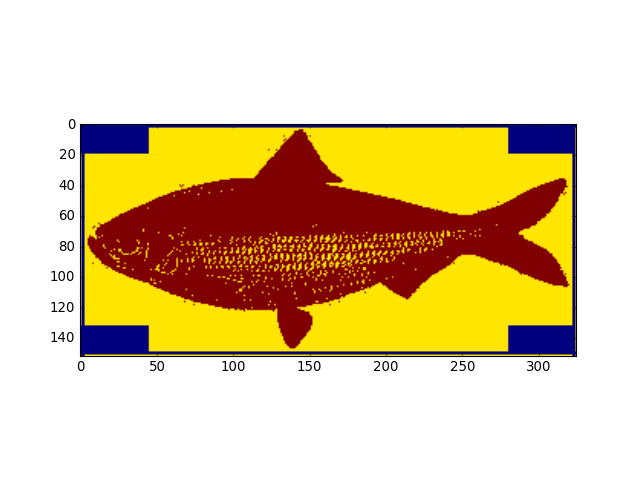

In [11]:
plt.figure(1)
plt.imshow(bg)

In [12]:
# Using OpenCV grabcut with obvious background initialization
rect = None

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

mask, bgdModel, fgdModel = cv2.grabCut(sample,bg,rect,bgdModel,fgdModel,15,cv2.GC_INIT_WITH_MASK)


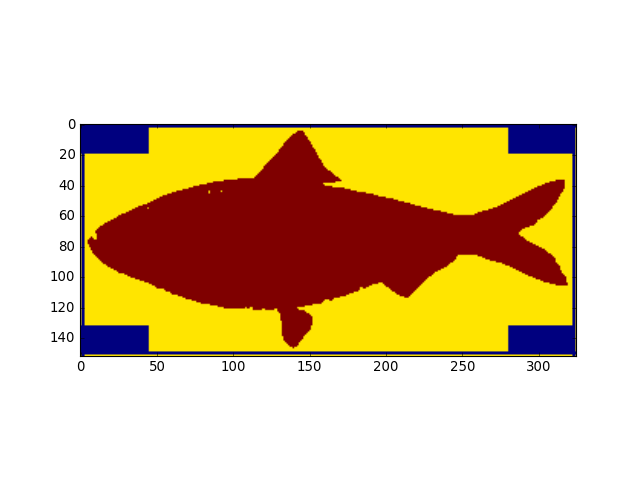

In [13]:
plt.figure(2)
plt.imshow(mask)


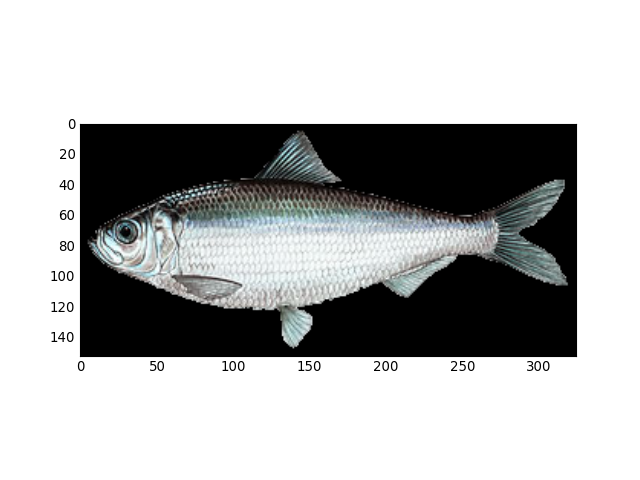

In [8]:
fish = cv2.bitwise_and(sample,sample,mask = (mask==3).astype('uint8'))
plt.figure(3)
plt.imshow(fish)